# MP Plus data train

加入物理特征进行训练
**物理特征包括：**
nsites、crystal_system、space_group、volume、density、
density_atomic、efermi、energy_per_atom、formation_energy_per_atom、is_gap_direct、is_oxide


In [1]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
FIG_SHOW = False

In [2]:
current_path = os.getcwd()
current_path

'c:\\Users\\Fortyfour\\Desktop\\graduation_design\\New_Scripts\\Bg_pre2'

In [3]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../'))
# Importing the custom module
from Utools.SingleModel import SingleModel
from Utools.draw import plot_feature_importance

In [4]:
from sklearn.base import clone
# Import sklearn models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyRegressor

## Load Data

In [5]:
# Load data
file_dir = os.path.join(current_path, './Data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'rfe_train_data', 'mp_train_set.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'mp_test_set.csv'))
# dft_plus data
dft_plus_train = pd.read_csv(os.path.join(file_dir, 'rfe_train_data', 'mp_plus_train_set.csv'))
dft_plus_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'mp_plus_test_set.csv'))    

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']

dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']

dft_plus_train_X = dft_plus_train.drop(columns=['composition', 'band_gap'])
dft_plus_train_y = dft_plus_train['band_gap']   
dft_plus_test_X = dft_plus_test.drop(columns=['composition', 'band_gap'])
dft_plus_test_y = dft_plus_test['band_gap']

In [6]:
dft_train.shape, dft_test.shape, dft_plus_train.shape, dft_plus_test.shape

((7869, 119), (1963, 119), (7869, 130), (1963, 130))

## Model Train

In [7]:
# define dft_models with the best hyper parameters
dft_models = {
    # Dummy models
    'Dummy': DummyRegressor(strategy='mean'),
    # GBDT models
    'GBR': GradientBoostingRegressor(
    n_estimators=500, learning_rate=0.05, max_depth=10, 
    max_features=0.25, subsample=1.0, random_state=RANDOM_SEED),

    'LightGBM': LGBMRegressor(learning_rate=0.2, max_depth=-1, n_estimators=500,
    subsample=0.7, colsample_bytree=1.0,
    objective='regression', random_state=RANDOM_SEED, n_jobs=-1),

    'XGBoost': XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=500,
    colsample_bytree=0.7, subsample=1.0, reg_lambda=1.0, alpha=0.5, 
    objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1),

    # Random Forest models
    'RandomForest': RandomForestRegressor(
    n_estimators=500, max_depth=None, min_samples_split=2, min_samples_leaf=1,
    max_features=0.25, random_state=RANDOM_SEED, n_jobs=-1),
    
    'ExtraRandomTrees': ExtraTreesRegressor(
    n_estimators=500, max_depth=None, min_samples_split=7, min_samples_leaf=1,
    max_features=0.5, random_state=RANDOM_SEED, n_jobs=-1),
    
    # 'KNN': KNeighborsRegressor(n_neighbors=5, weights='distance', metric='manhattan', p=2, n_jobs=-1),

    'KernelRidge': Pipeline([
    ('nystroem', Nystroem(kernel='rbf',  n_components=7500, random_state=RANDOM_SEED)),
    ('ridge', Ridge(alpha=0.05, random_state=RANDOM_SEED))]), 

    'SVR': SVR(kernel='rbf', C=25, epsilon=0.07, gamma=0.01)
}

### DFT Model

In [8]:
fig_path = os.path.join(current_path, 'figures', 'MP_plus')
os.makedirs(fig_path, exist_ok=True)
# save model performance as df
metrics_df = pd.DataFrame(columns=['Model', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE', 'MAPE'])
# feature importance path
feature_importance_path = os.path.join(current_path, 'metrics', 'feature_importance')
os.makedirs(feature_importance_path, exist_ok=True)

In [9]:
model_number = 0
model_nums = len(dft_models)
# Loop through each model
for model_name, model in dft_models.items():
    model_number += 1
    # Create directories for figures
    fig_path = os.path.join(current_path, 'figures', 'MP_plus', model_name)
    # Create directories if don't exist
    os.makedirs(fig_path, exist_ok=True)

    # record model metrics
    model_metrics = pd.DataFrame(columns=['Model', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE', 'MAPE'])

    # Train the model on dft data
    print("#" * 100)
    print(f"[{model_number}/{model_nums} - DFT - {model_name}] Training {model_name} on DFT data:")
    print("-" * 100)
    
    dft_model = SingleModel(clone(model), random_state=RANDOM_SEED)
    dft_model.train(dft_train_X, dft_train_y)
    # evaluate on the dft test set
    print(f"[1 - DFT->DFT] Evaluating DFT {model_name} on DFT test set:")
    
    metrics = dft_model.evaluate(dft_test_X, dft_test_y, fig_path=os.path.join(fig_path, 'dft.png'), fig_show=FIG_SHOW)
    model_metrics.loc[len(model_metrics)] = {
    'Model': f"{model_name}",
    'Train_set': 'dft',
    'Test_set': 'dft',
    'R²': metrics['r2'],
    'RMSE': metrics['rmse'],
    'MAE': metrics['mae'],
    'MAPE': metrics['mape']
}
   

    metrics_df = pd.concat([metrics_df, model_metrics], ignore_index=True)
    #################################################
    # Feature importance plot
    # For models that support feature importance
    if model_name in ['GBR', 'LightGBM', 'XGBoost', 'RandomForest', 'ExtraRandomTrees']:
        # 
        print(f"Plotting feature importance for {model_name} on DFT data:")
        dft_importances_df = plot_feature_importance(dft_model.get_model(), dft_train_X.columns, top_n=10,
                            fig_path=os.path.join(fig_path, f'dft_feature_importance.png'), fig_show=FIG_SHOW)
        # 之前已经保存，所以这里不需要再保存了
        # # Save the feature importance DataFrame to a CSV file
        # dft_feature_importance_path = os.path.join(feature_importance_path, 'dft')
        # os.makedirs(dft_feature_importance_path, exist_ok=True)
        # dft_importances_df.to_csv(os.path.join(dft_feature_importance_path, f'dft_{model_name}_feature_importance.csv'), index=False)

####################################################################################################
[1/8 - DFT - Dummy] Training Dummy on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
Model training completed!
[1 - DFT->DFT] Evaluating DFT Dummy on DFT test set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\MP_plus\Dummy\dft.png

Model Evaluation Results:
Test set size: 1963
Test set: R²: -0.0002 RMSE: 0.8696 MAE: 0.7471 MAPE: 2159.8941%
####################################################################################################
[2/8 - DFT - GBR] Training GBR on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipel

C:\Users\Fortyfour\AppData\Local\Temp\ipykernel_9768\381430853.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, model_metrics], ignore_index=True)


[Pipeline] ............. (step 2 of 2) Processing model, total= 1.2min
Model training completed!
[1 - DFT->DFT] Evaluating DFT GBR on DFT test set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\MP_plus\GBR\dft.png

Model Evaluation Results:
Test set size: 1963
Test set: R²: 0.6743 RMSE: 0.4962 MAE: 0.3510 MAPE: 1366.0363%
Plotting feature importance for GBR on DFT data:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\MP_plus\GBR\dft_feature_importance.png
####################################################################################################
[3/8 - DFT - LightGBM] Training LightGBM on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004299 secon

e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\MP_plus\LightGBM\dft.png

Model Evaluation Results:
Test set size: 1963
Test set: R²: 0.6522 RMSE: 0.5128 MAE: 0.3663 MAPE: 1629.4972%
Plotting feature importance for LightGBM on DFT data:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\MP_plus\LightGBM\dft_feature_importance.png
####################################################################################################
[4/8 - DFT - XGBoost] Training XGBoost on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   5.3s
Model training completed!
[1 - DFT->DFT] Evaluating DFT XGBoost on DFT test set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\f

### Plus Model

In [10]:
model_number = 0
model_nums = len(dft_models)
# Loop through each model
for model_name, model in dft_models.items():
    model_number += 1
    # Create directories for figures
    fig_path = os.path.join(current_path, 'figures', 'MP_plus', model_name)
    # Create directories if don't exist
    os.makedirs(fig_path, exist_ok=True)

    # record model metrics
    model_metrics = pd.DataFrame(columns=['Model', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE', 'MAPE'])

    # Train the model on dft data
    print("#" * 100)
    print(f"[{model_number}/{model_nums} - DFT Plus - {model_name}] Training {model_name} on DFT Plus data:")
    print("-" * 100)
    
    dft_plus_model = SingleModel(clone(model), random_state=RANDOM_SEED)
    dft_plus_model.train(dft_plus_train_X, dft_plus_train_y)
    # evaluate on the dft test set
    print(f"[1 - Plus->Plus] Evaluating DFT Plus {model_name} on DFT Plus test set:")
    
    metrics = dft_plus_model.evaluate(dft_plus_test_X, dft_plus_test_y, fig_path=os.path.join(fig_path, 'plus.png'), fig_show=FIG_SHOW)
    model_metrics.loc[len(model_metrics)] = {
    'Model': f"{model_name}",
    'Train_set': 'plus',
    'Test_set': 'plus',
    'R²': metrics['r2'],
    'RMSE': metrics['rmse'],
    'MAE': metrics['mae'],
    'MAPE': metrics['mape']
}
   

    metrics_df = pd.concat([metrics_df, model_metrics], ignore_index=True)
    #################################################
    # Feature importance plot
    # For models that support feature importance
    if model_name in ['GBR', 'LightGBM', 'XGBoost', 'RandomForest', 'ExtraRandomTrees']:
        # 
        print(f"Plotting feature importance for {model_name} on DFT Plus data:")
        dft_importances_df = plot_feature_importance(dft_plus_model.get_model(), dft_plus_train_X.columns, top_n=10,
                            fig_path=os.path.join(fig_path, f'plus_feature_importance.png'), fig_show=FIG_SHOW)
        # Save the feature importance DataFrame to a CSV file
        plus_feature_importance_path = os.path.join(feature_importance_path, 'mp_plus')
        os.makedirs(plus_feature_importance_path, exist_ok=True)
        dft_importances_df.to_csv(os.path.join(plus_feature_importance_path, f'plus_{model_name}_feature_importance.csv'), index=False)

####################################################################################################
[1/8 - DFT Plus - Dummy] Training Dummy on DFT Plus data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
Model training completed!
[1 - Plus->Plus] Evaluating DFT Plus Dummy on DFT Plus test set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\MP_plus\Dummy\plus.png

Model Evaluation Results:
Test set size: 1963
Test set: R²: -0.0002 RMSE: 0.8696 MAE: 0.7471 MAPE: 2159.8941%
####################################################################################################
[2/8 - DFT Plus - GBR] Training GBR on DFT Plus data:
----------------------------------------------------------------------------------------------------


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\MP_plus\LightGBM\plus.png

Model Evaluation Results:
Test set size: 1963
Test set: R²: 0.6975 RMSE: 0.4783 MAE: 0.3439 MAPE: 1636.6815%
Plotting feature importance for LightGBM on DFT Plus data:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\MP_plus\LightGBM\plus_feature_importance.png
####################################################################################################
[4/8 - DFT Plus - XGBoost] Training XGBoost on DFT Plus data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   6.5s
Model training completed!
[1 - Plus->Plus] Evaluating DFT Plus XGBoost on DFT Plus test set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation

In [11]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Model,Train_set,Test_set,R²,RMSE,MAE,MAPE
11,XGBoost,plus,plus,0.701607,0.474978,0.333603,1609.092264
9,GBR,plus,plus,0.700031,0.476231,0.339434,1463.807196
10,LightGBM,plus,plus,0.697464,0.478264,0.343921,1636.681538
13,ExtraRandomTrees,plus,plus,0.681907,0.490406,0.353351,1653.832129
1,GBR,dft,dft,0.674300,0.496236,0.350958,1366.036324
3,XGBoost,dft,dft,0.672557,0.497562,0.350446,1768.524391
14,KernelRidge,plus,plus,0.666639,0.502038,0.358716,1760.758859
5,ExtraRandomTrees,dft,dft,0.661547,0.505858,0.364520,1591.355507
15,SVR,plus,plus,0.654340,0.511215,0.354427,1772.602084
2,LightGBM,dft,dft,0.652165,0.512821,0.366253,1629.497175


In [12]:
# Save the model metrics to a CSV file
metrics_df.to_csv(os.path.join('./metrics', 'mp_plus_metrics.csv'), index=False)

### 绘图比较

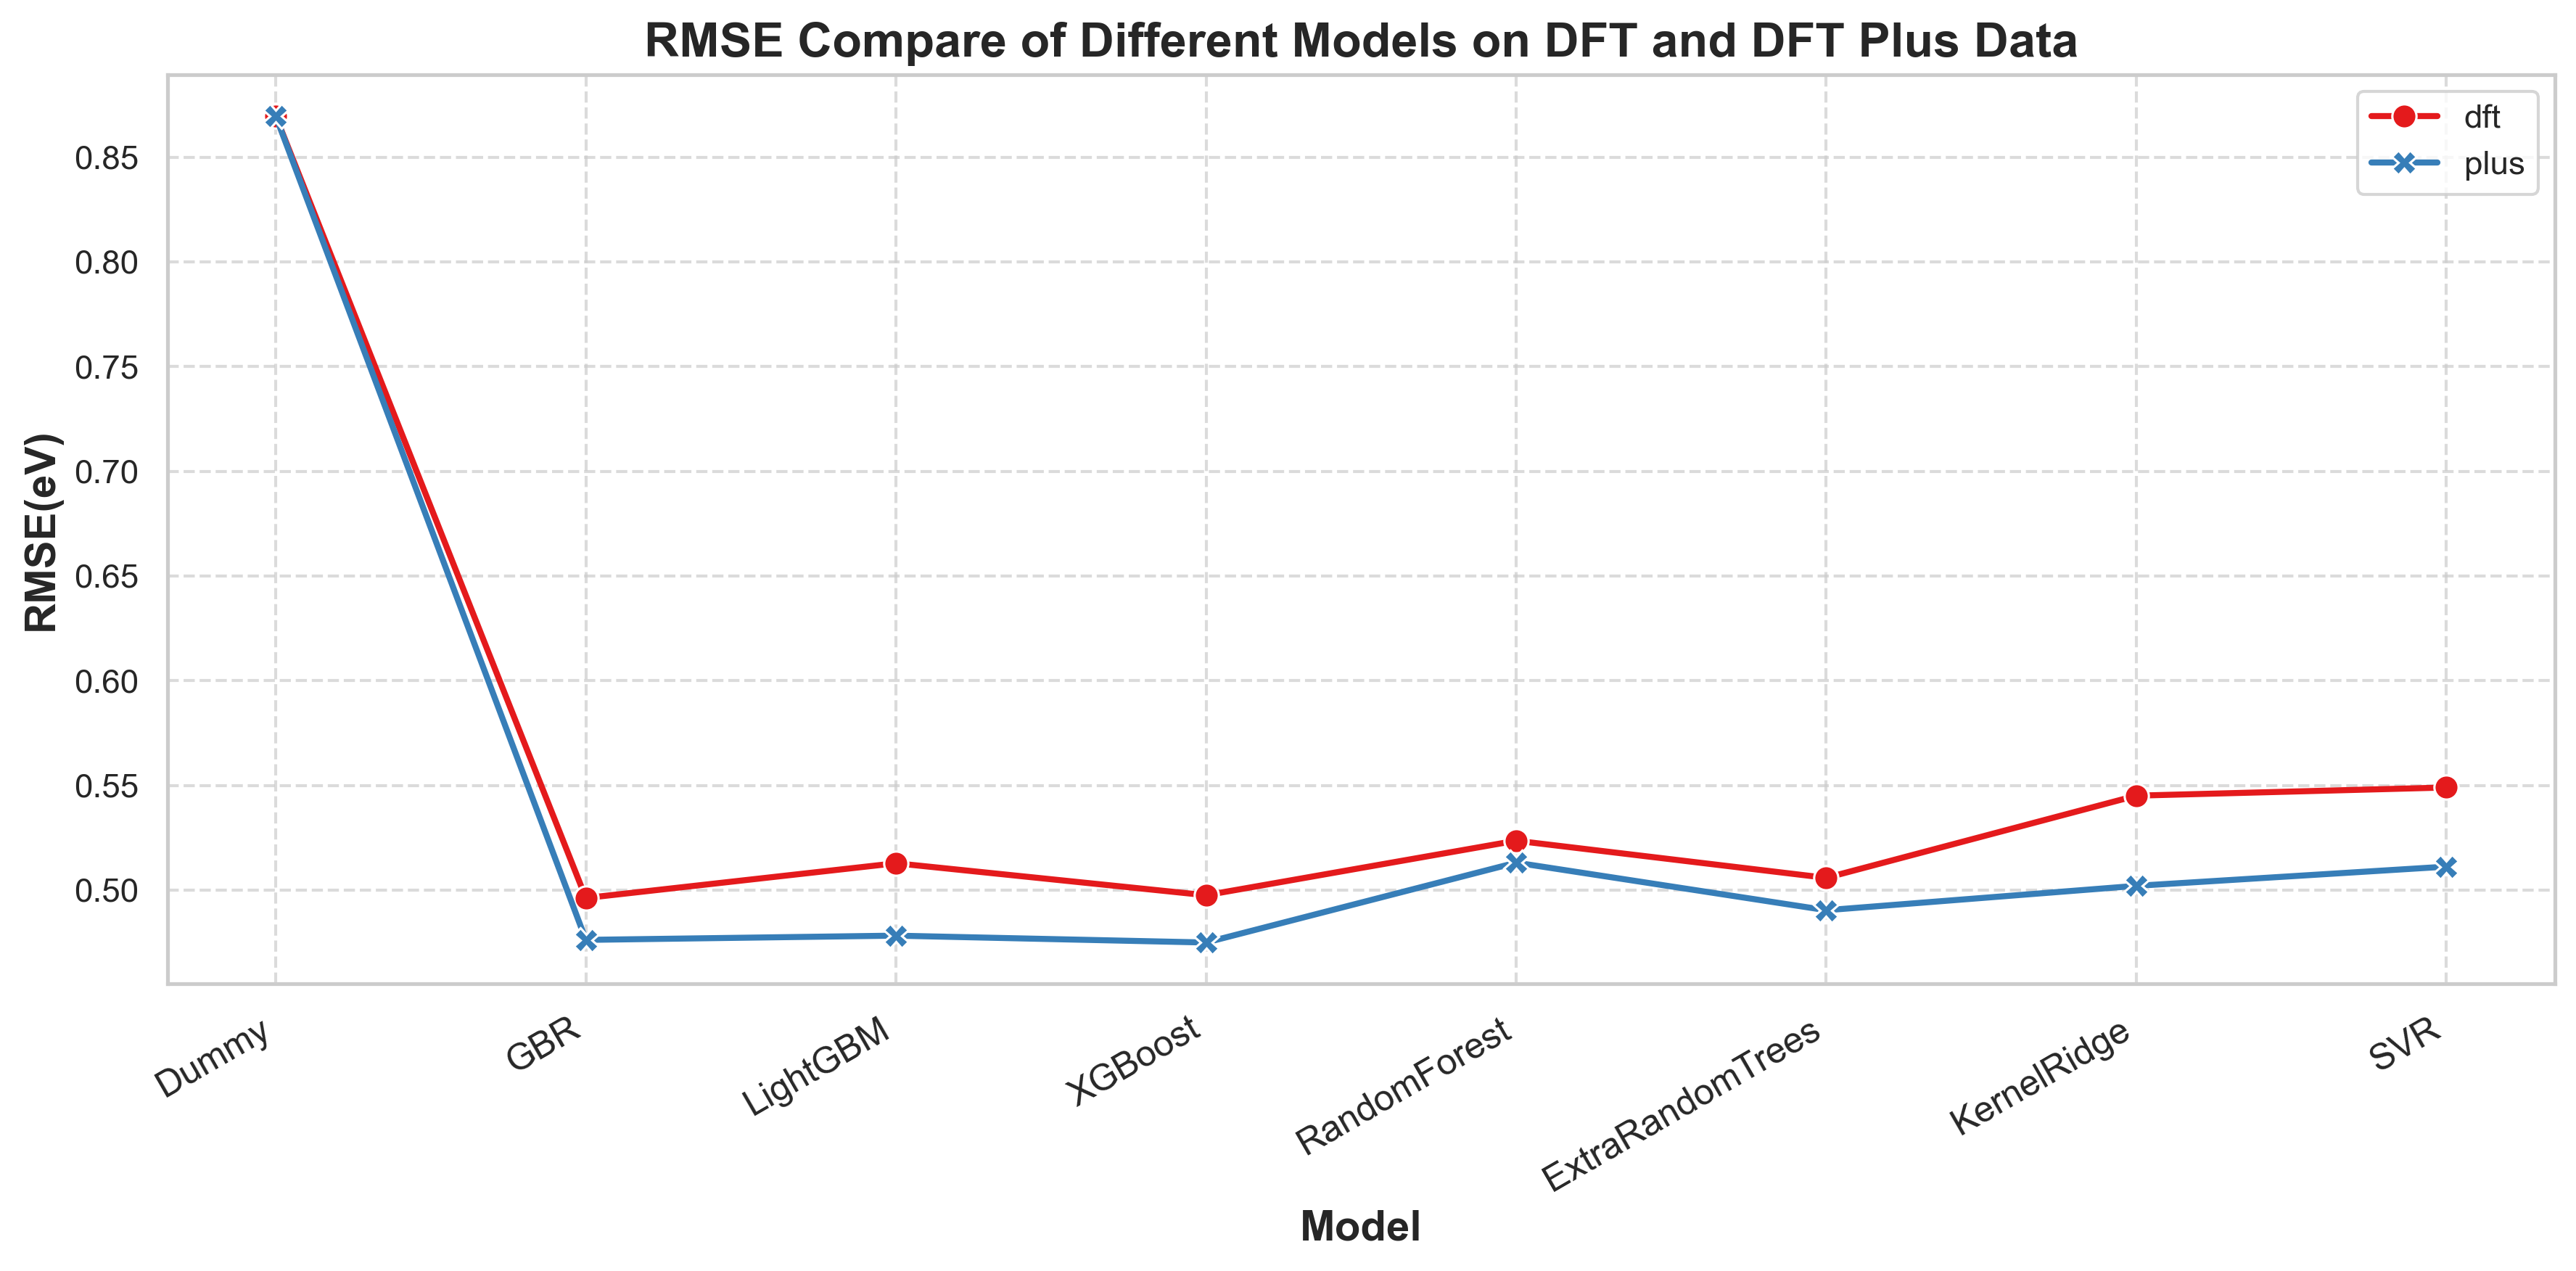

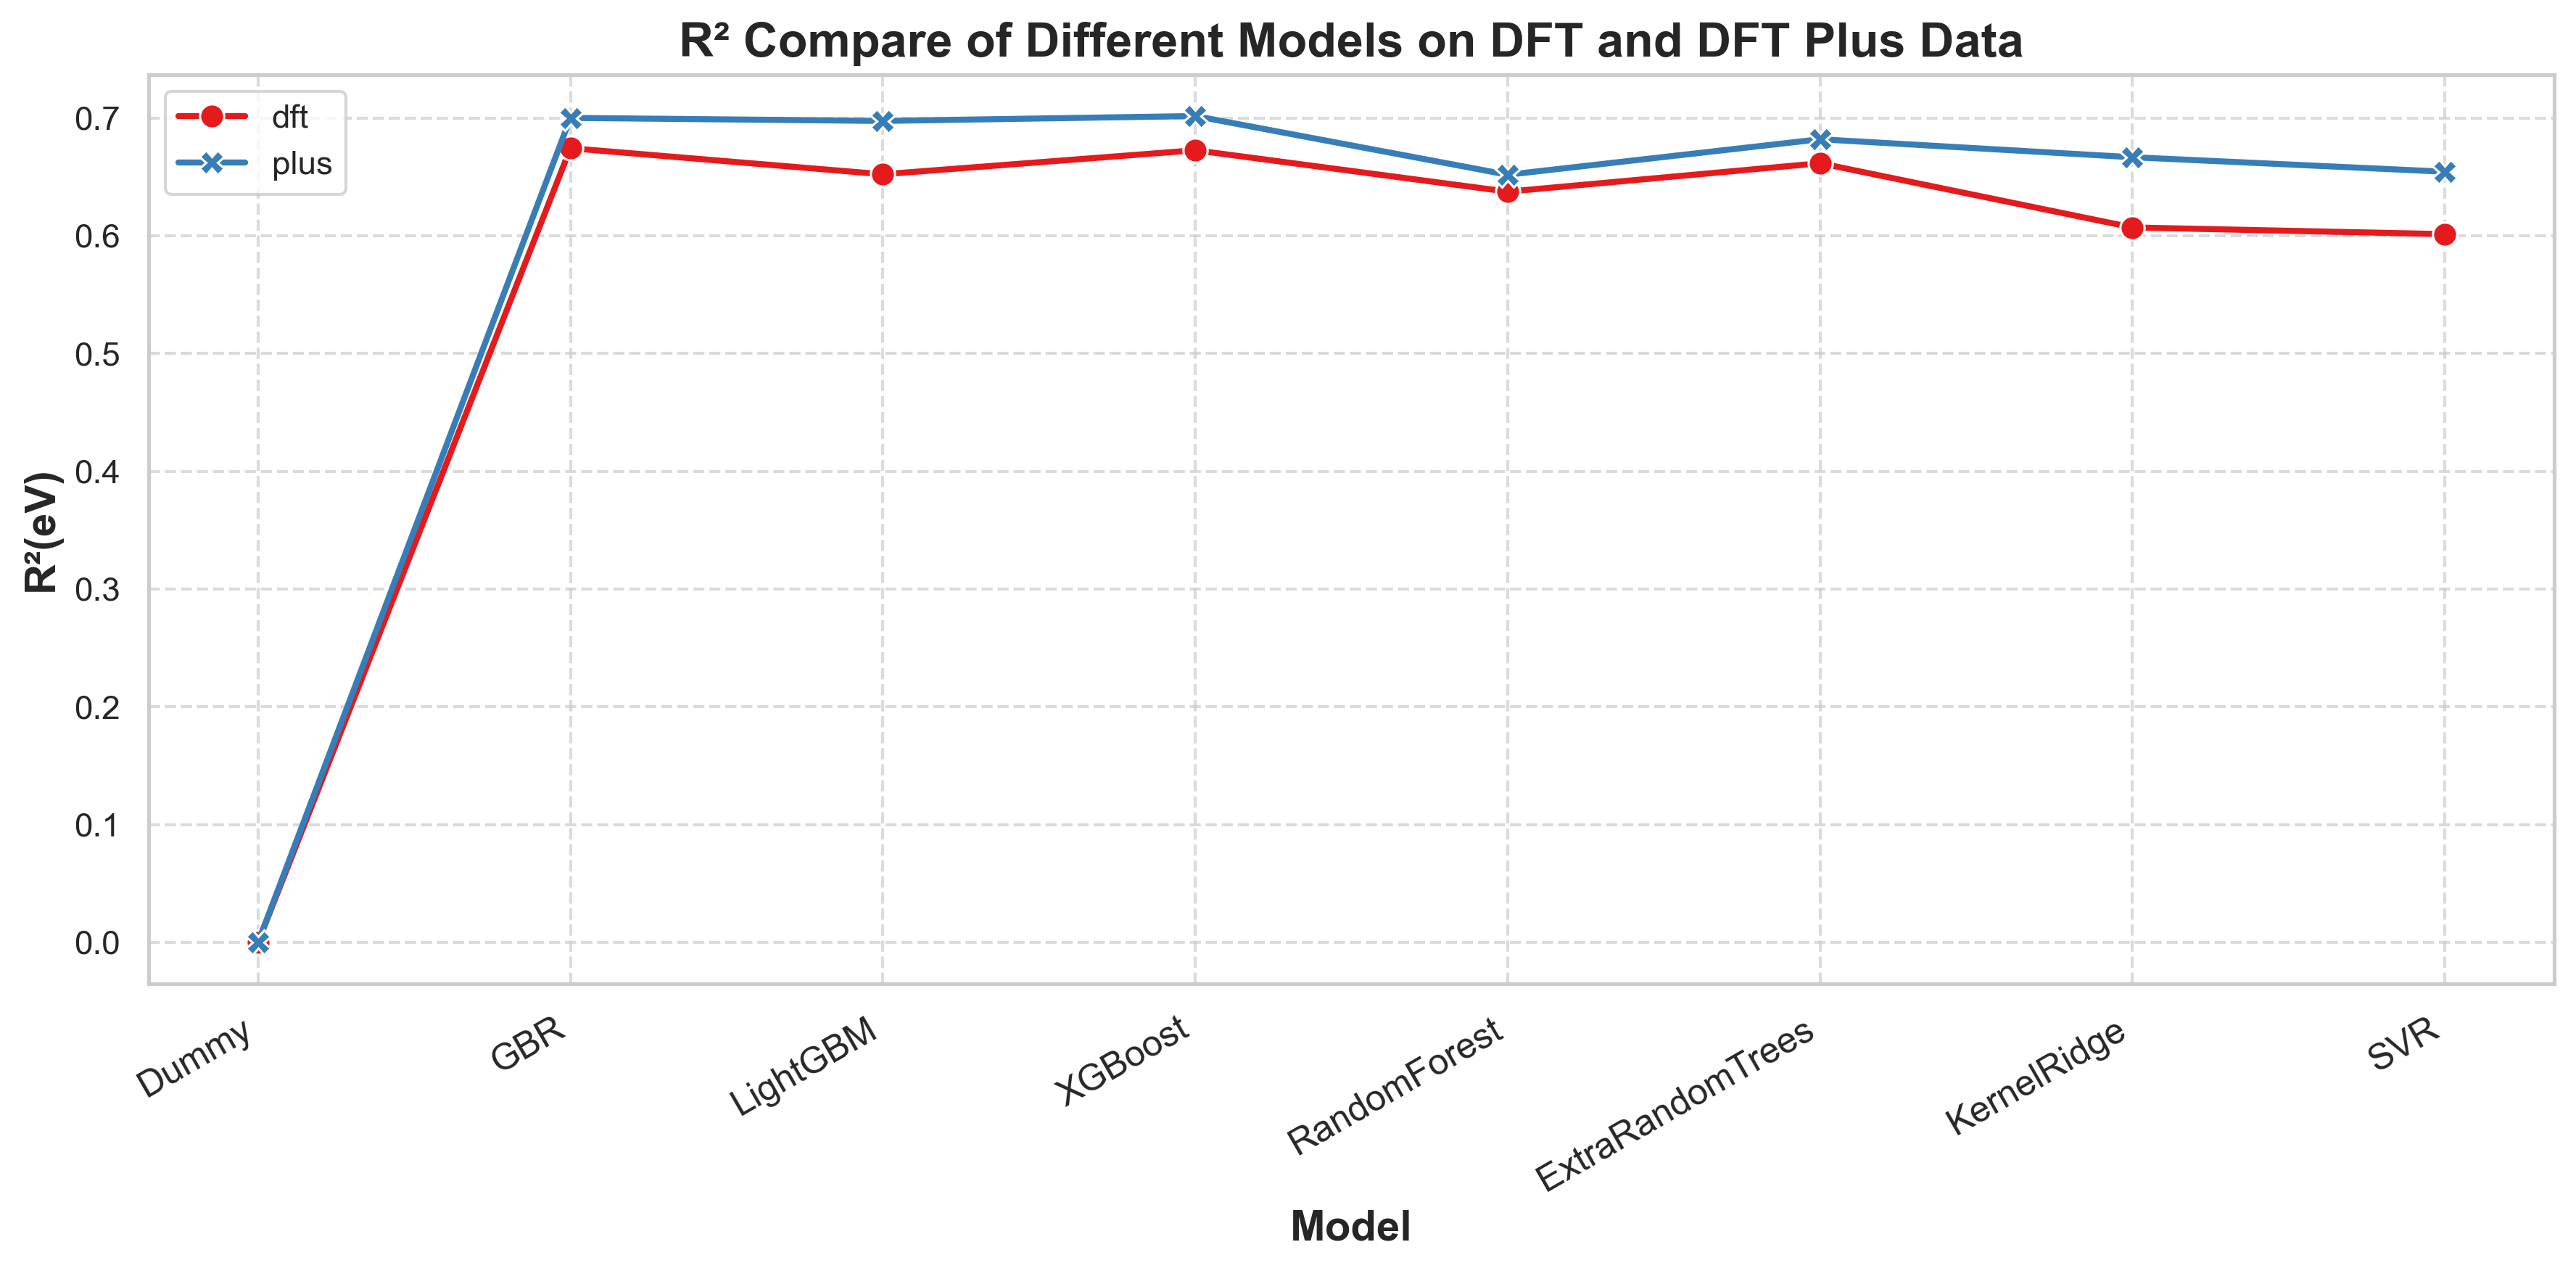

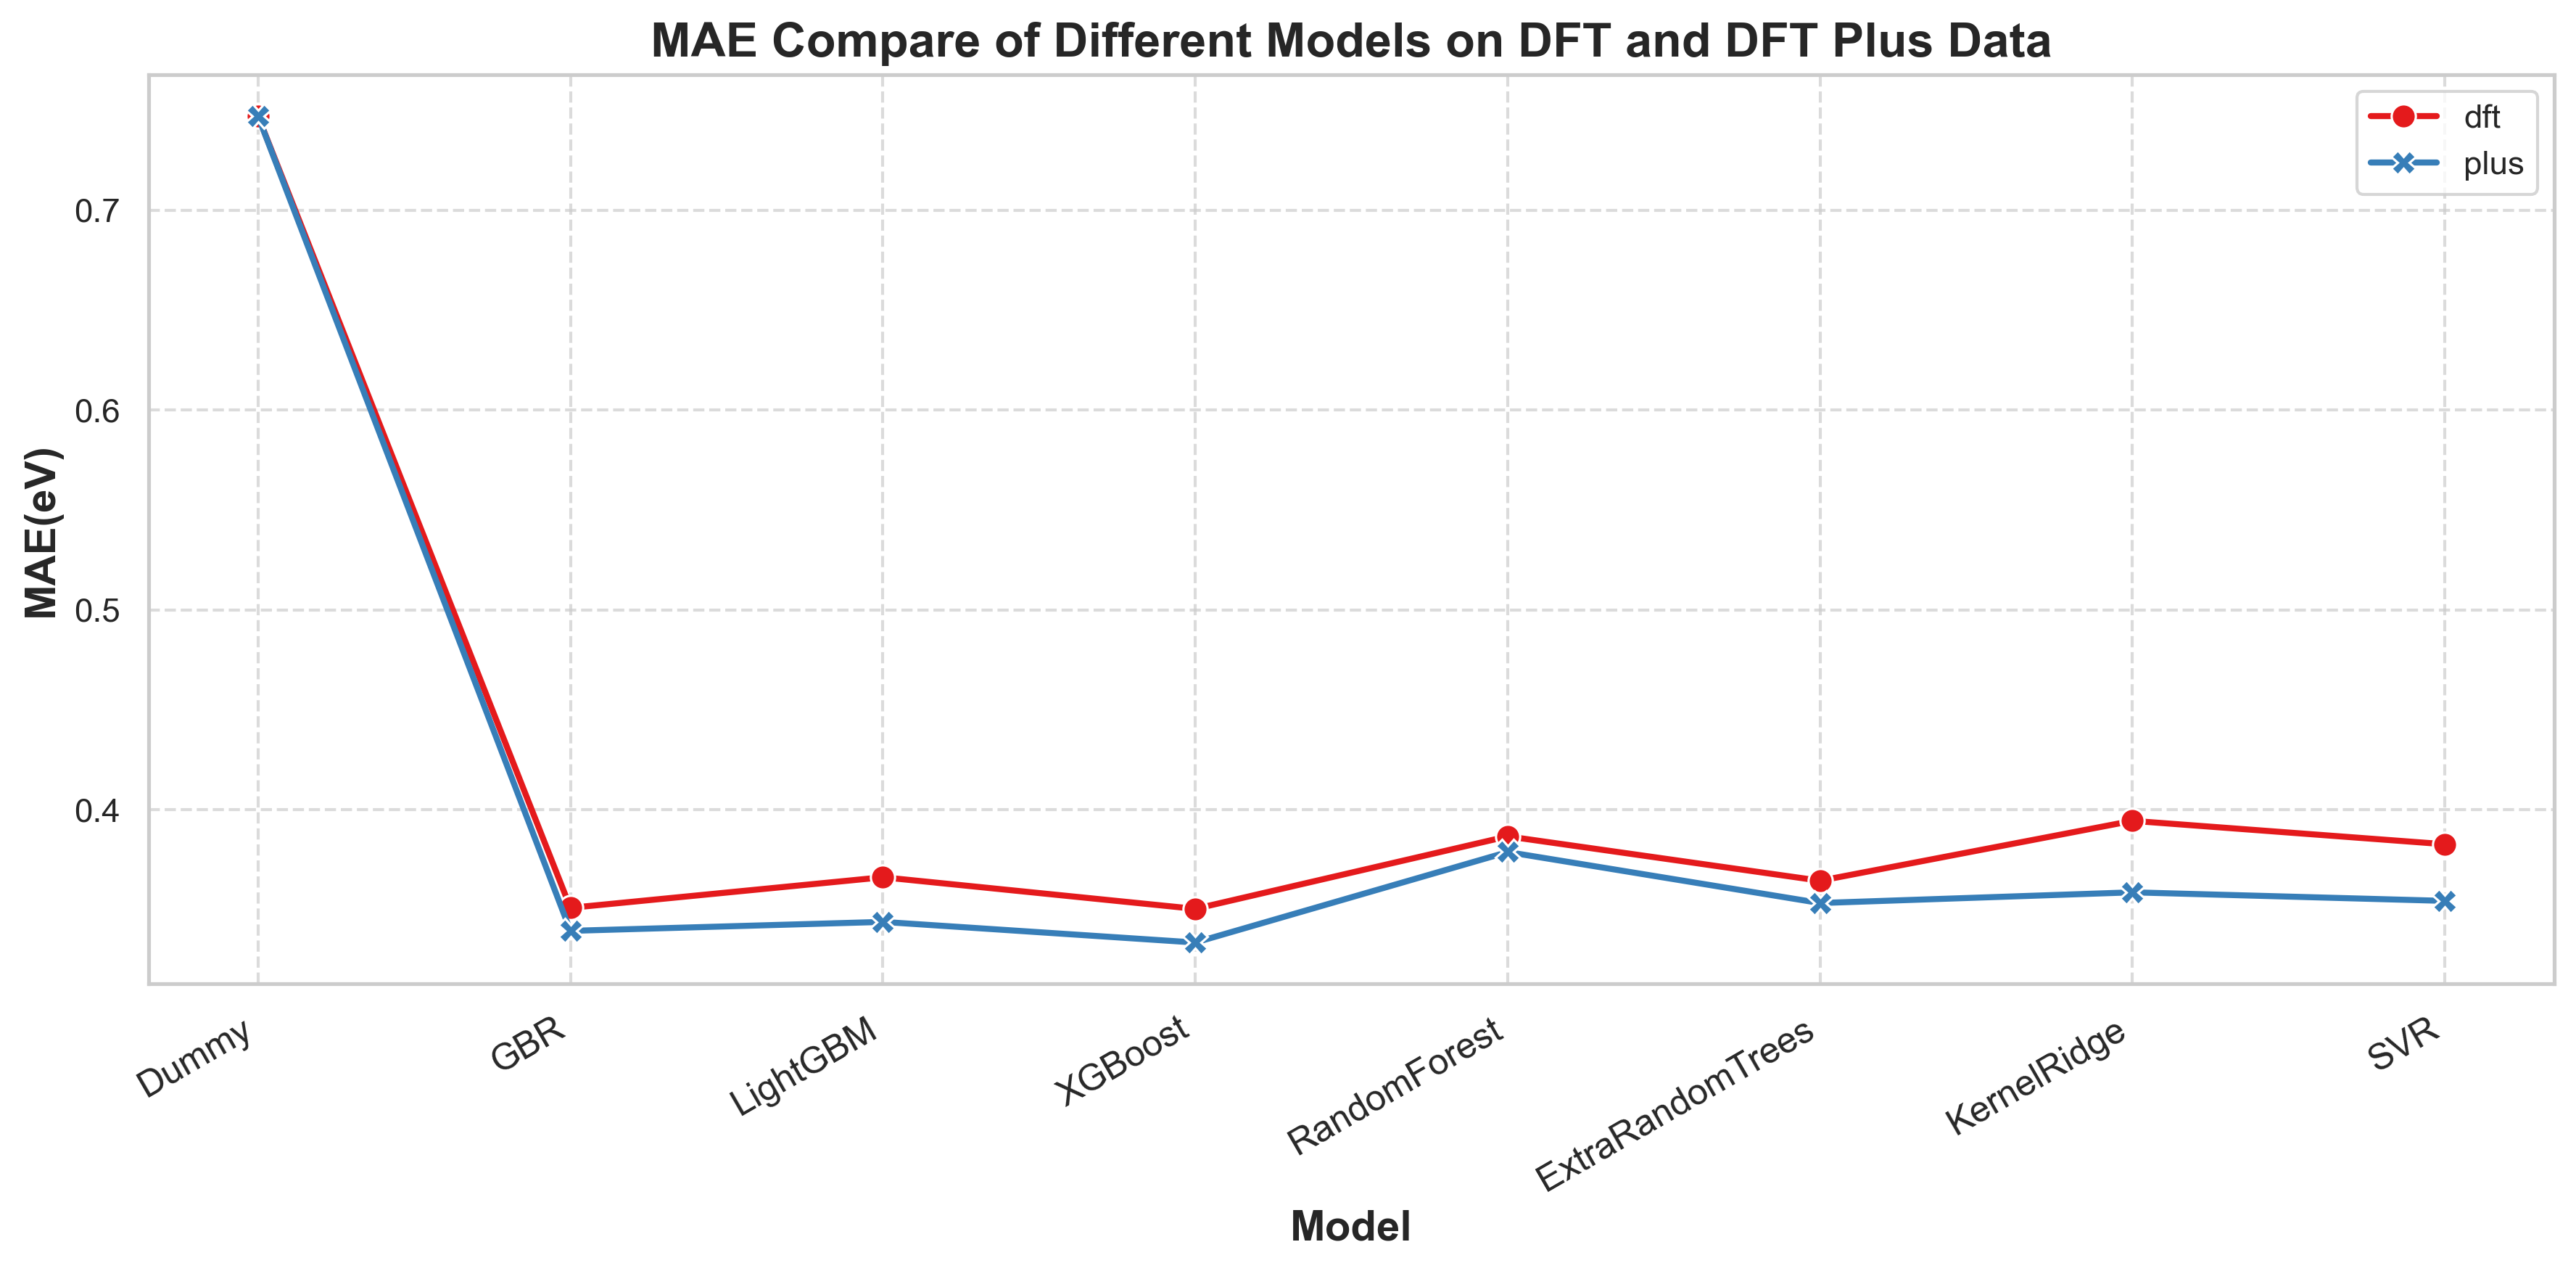

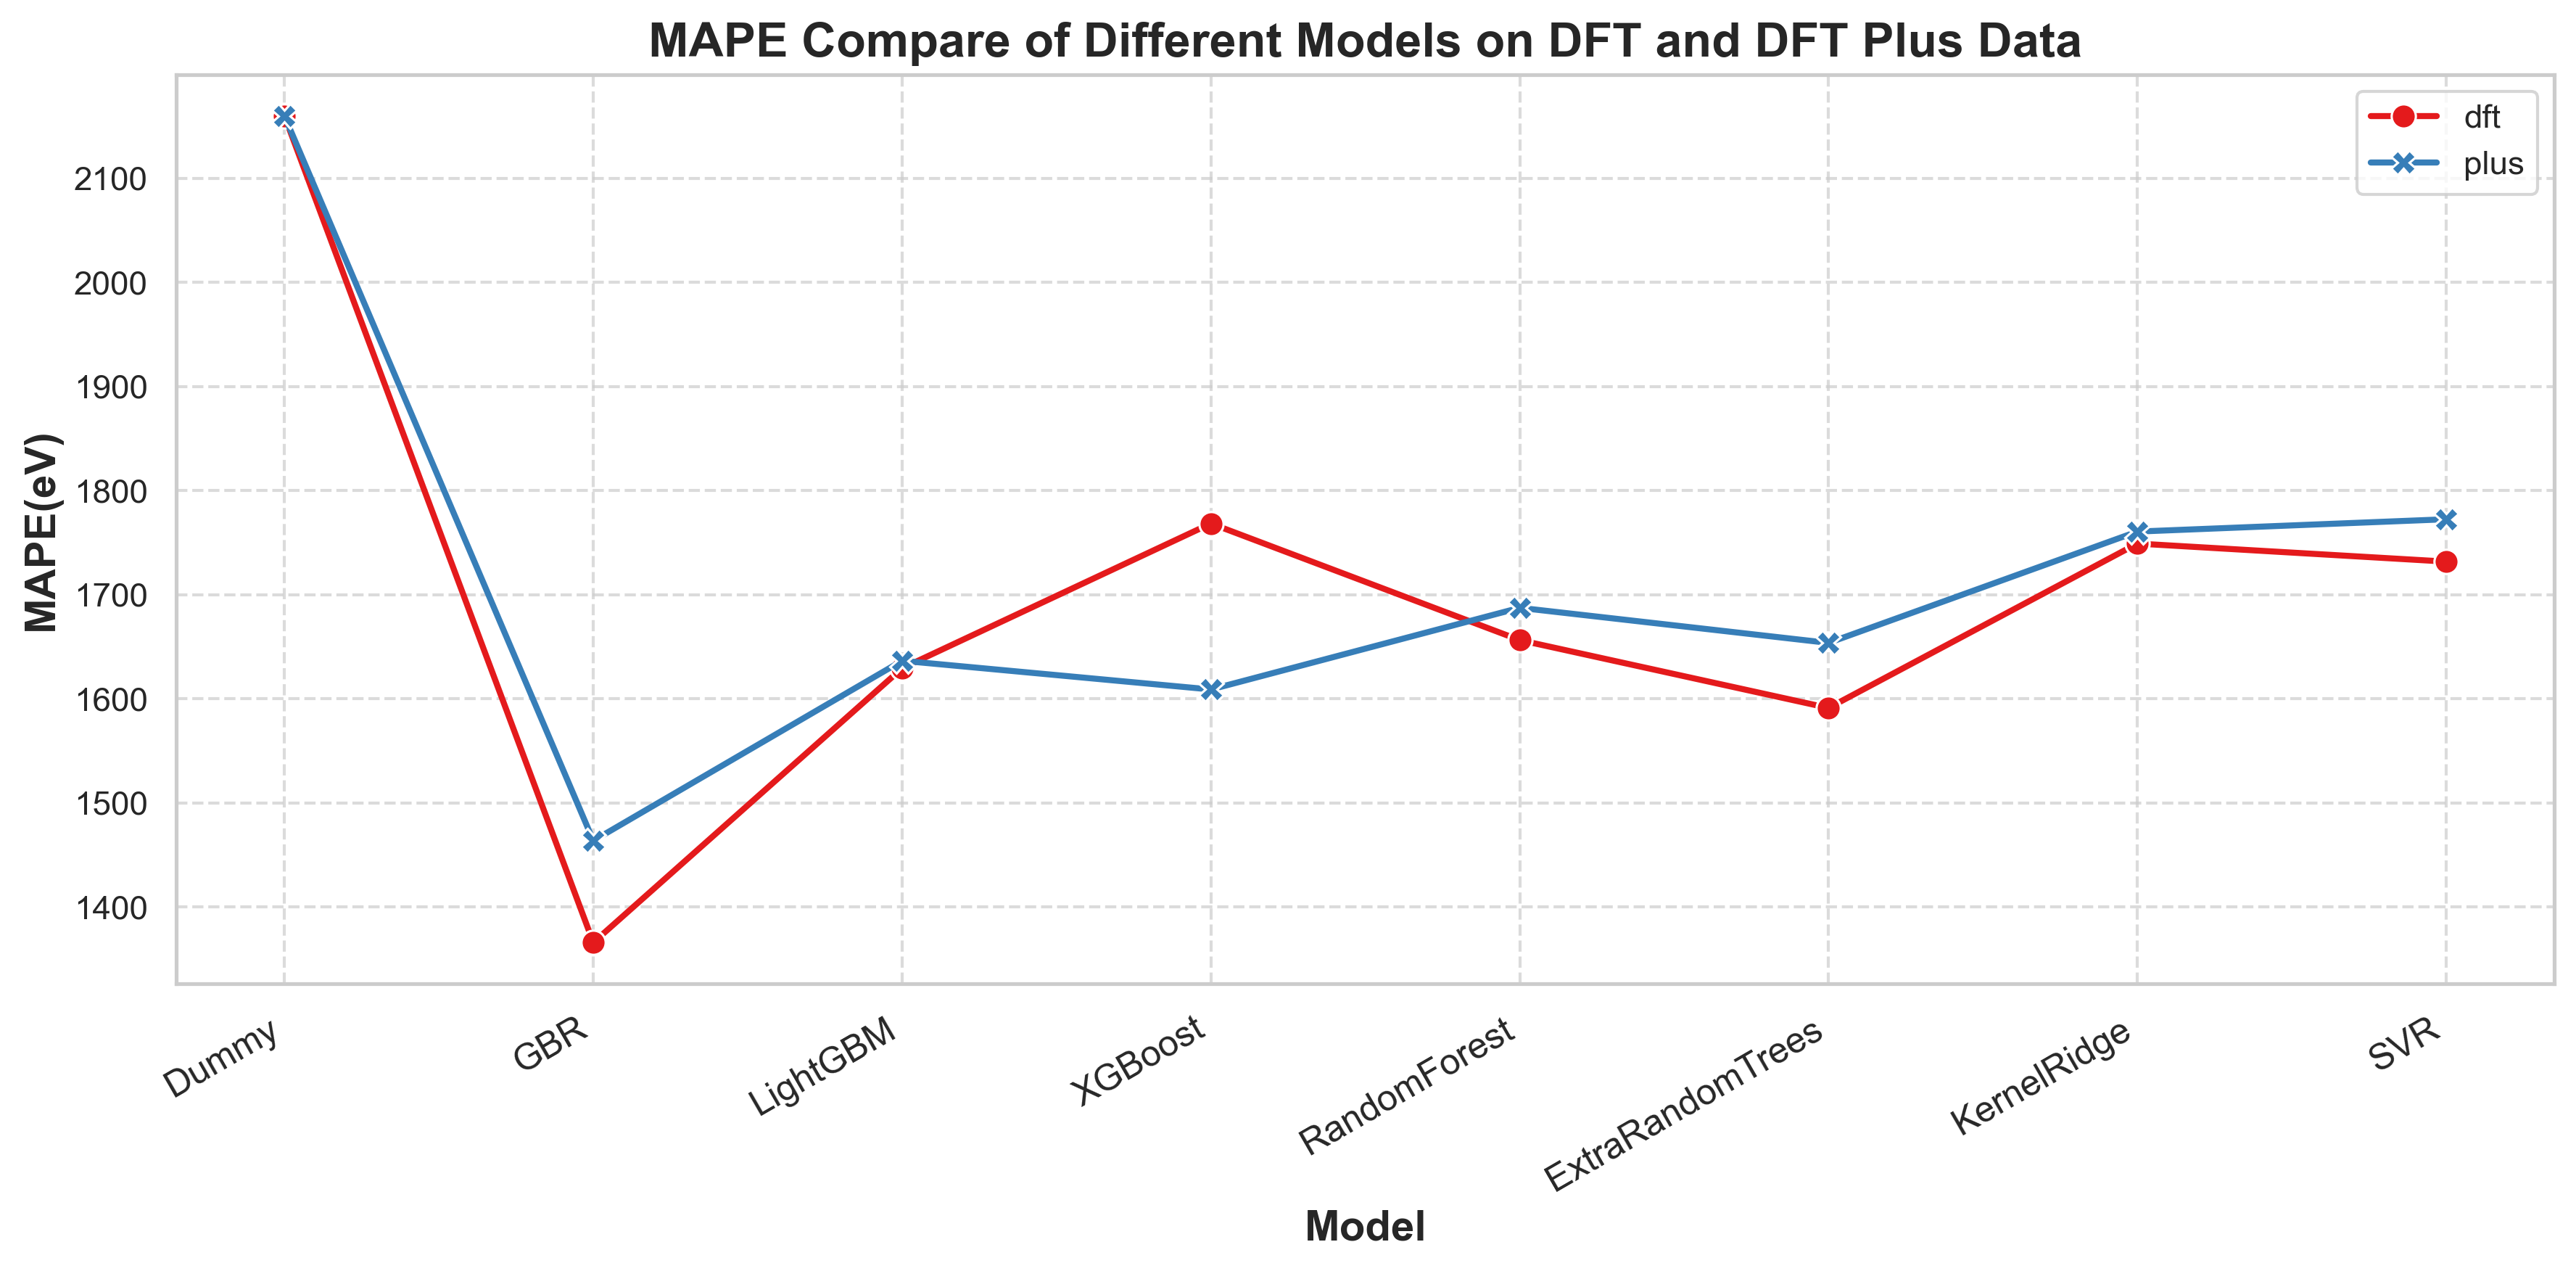

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. draw the metrics comparison figure

for metric_name in ['RMSE', 'R²', 'MAE', 'MAPE']:

    # set style
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6), dpi=300)

    # get unique models
    models = dft_models.keys()

    # prepare data for plotting
    plot_data = []
    for model in models:
        model_metrics = metrics_df[metrics_df['Model'] == f"{model}"]
        for _, row in model_metrics.iterrows():
            plot_data.append({
                'Model': row['Model'],
                'Training': row['Train_set'],
                'Testing': row['Test_set'],
                metric_name: row[metric_name]
            })

    plot_df = pd.DataFrame(plot_data)


    sns.lineplot(data=plot_df, x='Model', y=metric_name, hue='Training', style='Training',
                markers=True, dashes=False, palette='Set1', lw=2, markersize=8)

    # beautify the plot
    plt.title(f'{metric_name} Compare of Different Models on DFT and DFT Plus Data', fontsize=16, weight='bold')
    plt.xlabel('Model', fontsize=14, weight='bold')
    plt.ylabel(f'{metric_name}(eV)', fontsize=14, weight='bold')
    plt.xticks(rotation=30, ha='right', fontsize=12)
    # set the legend on the right top corner
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()  # adjust layout to fit all elements


    # save the figure
    fig_path = os.path.join(current_path, 'figures', 'metrics_comparison', 'dft_plus')
    os.makedirs(fig_path, exist_ok=True)
    plt.savefig(os.path.join(fig_path, f'{metric_name}_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

## 误差分析
**未修改实现**

In [14]:
y_pred = dft_model.predict(dft_test_X)
y_pred

array([1.71975864, 1.68337062, 1.10674452, ..., 1.75121938, 0.4718827 ,
       2.35866521], shape=(1963,))

In [15]:
dft_test['y_pred'] = y_pred
dft_test.head()

,composition,band_gap,maximum Number,mean Number,avg_dev Number,range Number,mean AtomicRadius,avg_dev AtomicRadius,minimum AtomicVolume,mean AtomicVolume,...,mean NpUnfilled,avg_dev NpUnfilled,mean NpValence,avg_dev NpValence,avg_dev NsValence,maximum ZungerPP-r_sigma,mean ZungerPP-r_sigma,avg_dev ZungerPP-r_sigma,range ZungerPP-r_sigma,y_pred
0,Ag12Ge6S36O126,2.8072,47.0,13.000000,7.000000,39.0,0.768333,0.235667,17.075648,13021.865068,...,1.933333,0.257778,3.666667,0.600000,0.124444,2.375,0.755833,0.407167,1.910,1.719759
1,Ag8H16S12O48,2.8821,47.0,11.523810,8.036281,46.0,0.685714,0.263946,17.075648,14175.915462,...,1.428571,0.816327,2.857143,1.632653,0.408163,2.375,0.887143,0.482449,1.910,1.683371
2,Ag16P8Se24,1.1866,47.0,35.166667,7.888889,32.0,1.275000,0.216667,17.075648,23.998639,...,1.500000,1.000000,2.500000,1.666667,0.444444,2.375,1.640833,0.489444,1.135,1.106745
3,Ag12Te6O24,0.0001,52.0,25.428571,19.918367,44.0,1.000000,0.457143,17.075648,10633.842379,...,1.428571,0.816327,2.857143,1.632653,0.408163,2.375,1.182857,0.820408,1.910,0.534630
4,Ag3As1F12,0.0994,47.0,17.625000,12.937500,38.0,0.746875,0.370312,17.075648,13955.765857,...,0.937500,0.351562,3.937500,1.593750,0.304688,2.375,0.837500,0.648750,1.970,1.281904


In [16]:
dft_test['error'] = np.abs(dft_test['y_pred'] - dft_test['band_gap'])
dft_test['error'].describe()

count    1963.000000
mean        0.382775
std         0.393659
min         0.000037
25%         0.112060
50%         0.259850
75%         0.524031
max         2.940268
Name: error, dtype: float64

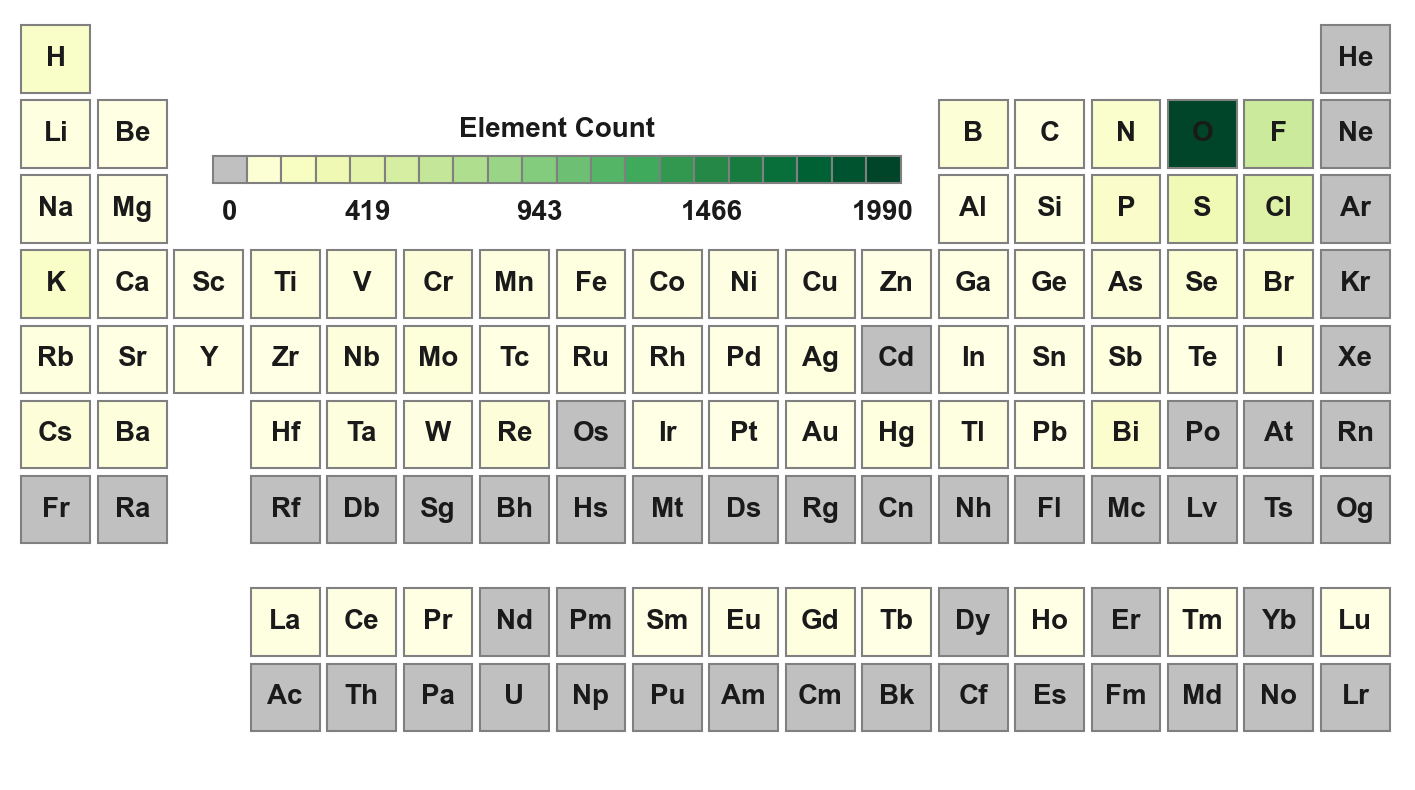

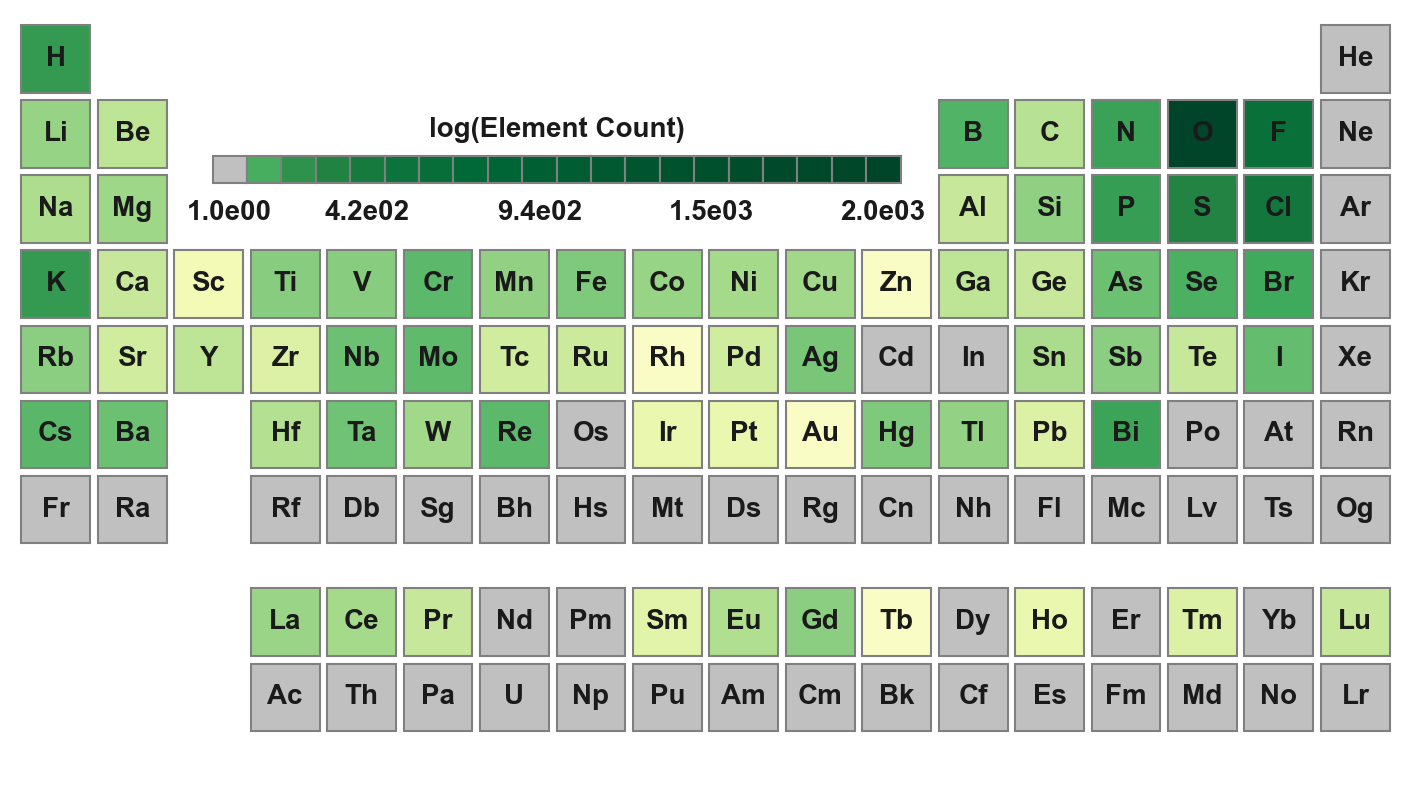

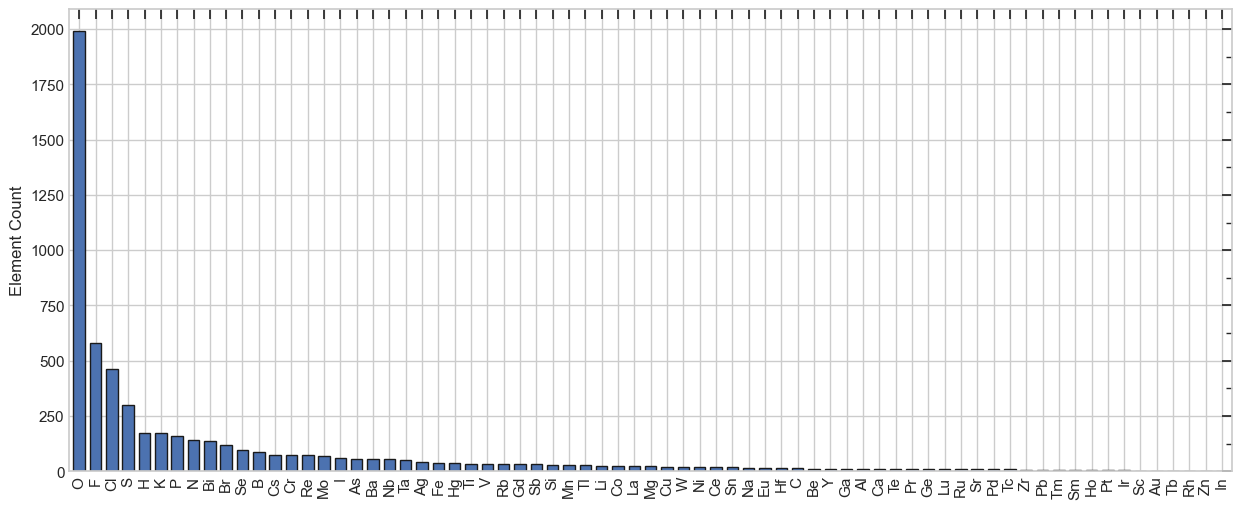

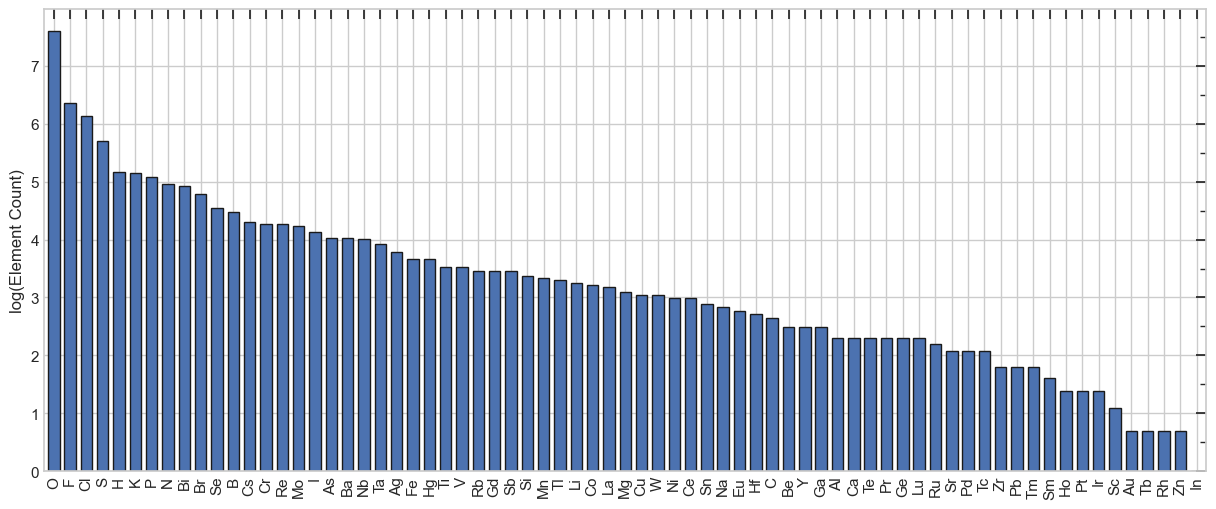

In [17]:
# 误差大于1eV的元素分布
from Utools.ML_figures.figures import element_prevalence
import matplotlib.pyplot as plt

data_df = dft_test[dft_test['error'] > 1.0].copy()
current_dir = os.getcwd()
os.chdir('./Utools')  # Change to where ML_figures is a direct subdirectory

formula = data_df['composition']
save_dir = os.path.join(fig_path, 'error_greater_than_1eV_elements_distribution')
os.makedirs(save_dir, exist_ok=True)
element_prevalence(formula,
                   name='element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=True)

plt.rcParams.update({'font.size': 12})
element_prevalence(formula,
                   name='element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=True)

os.chdir(current_dir)  # Return to previous directory

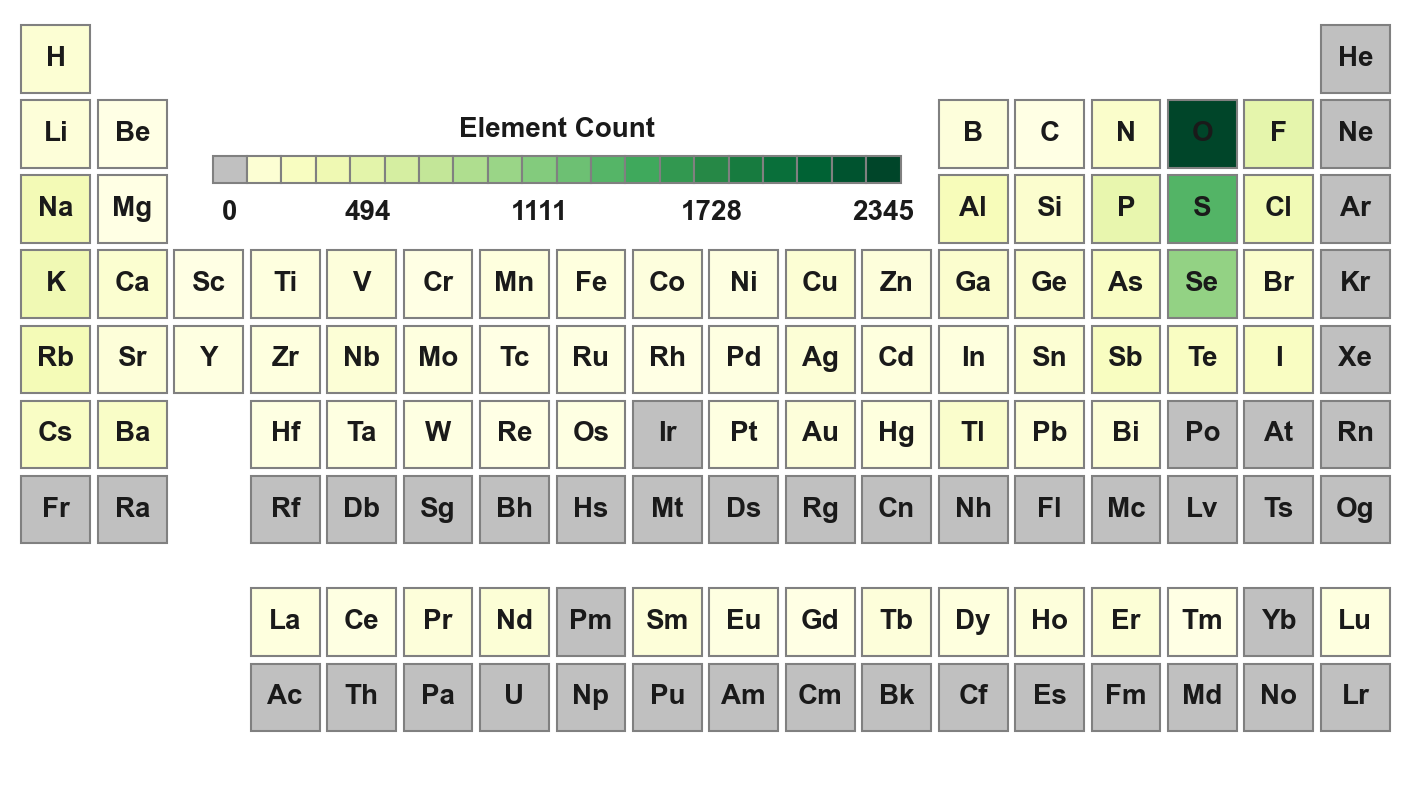

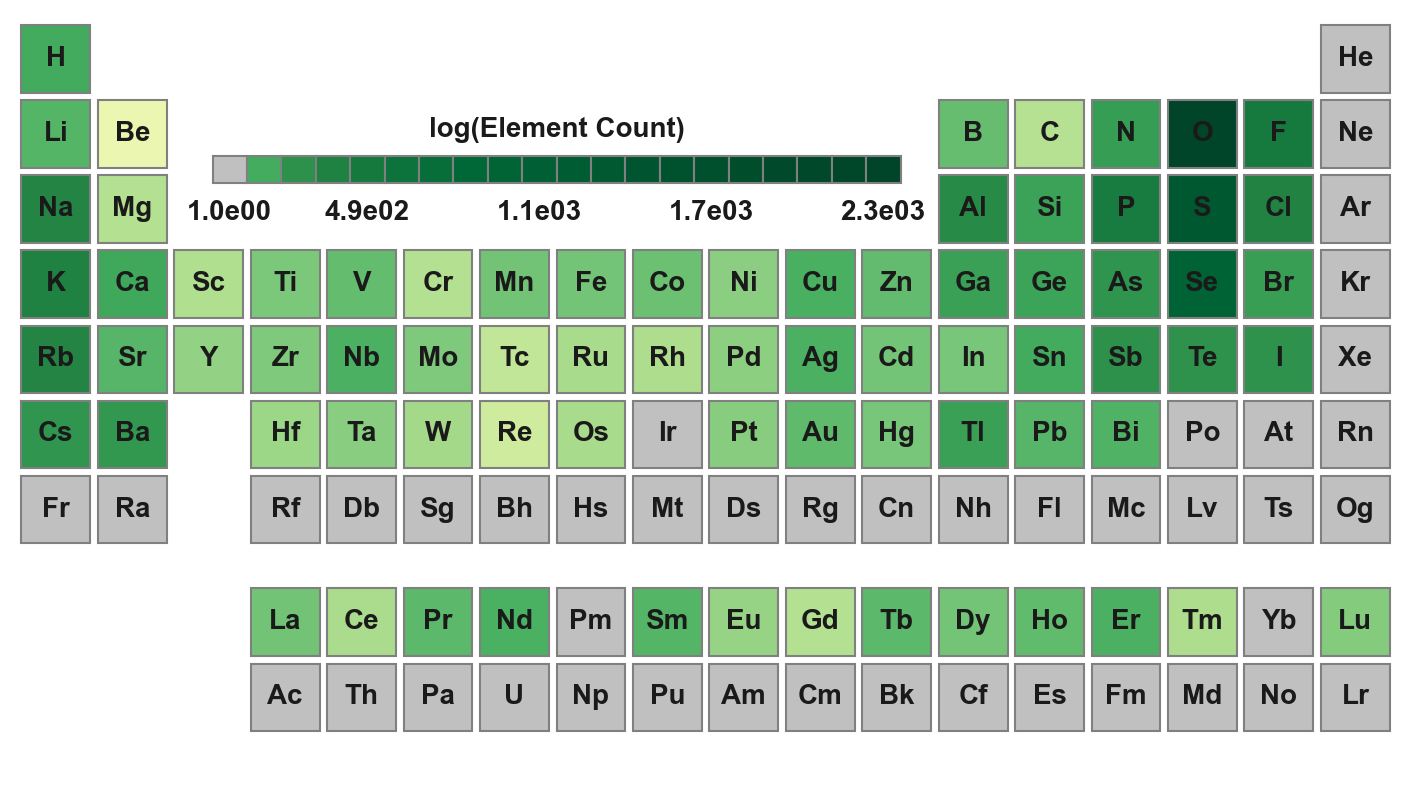

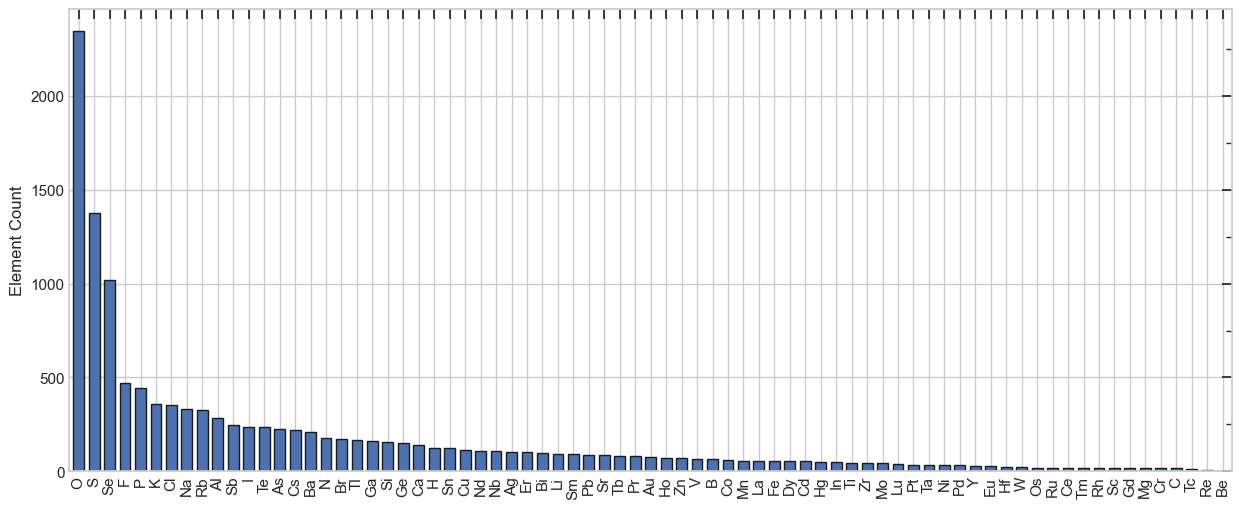

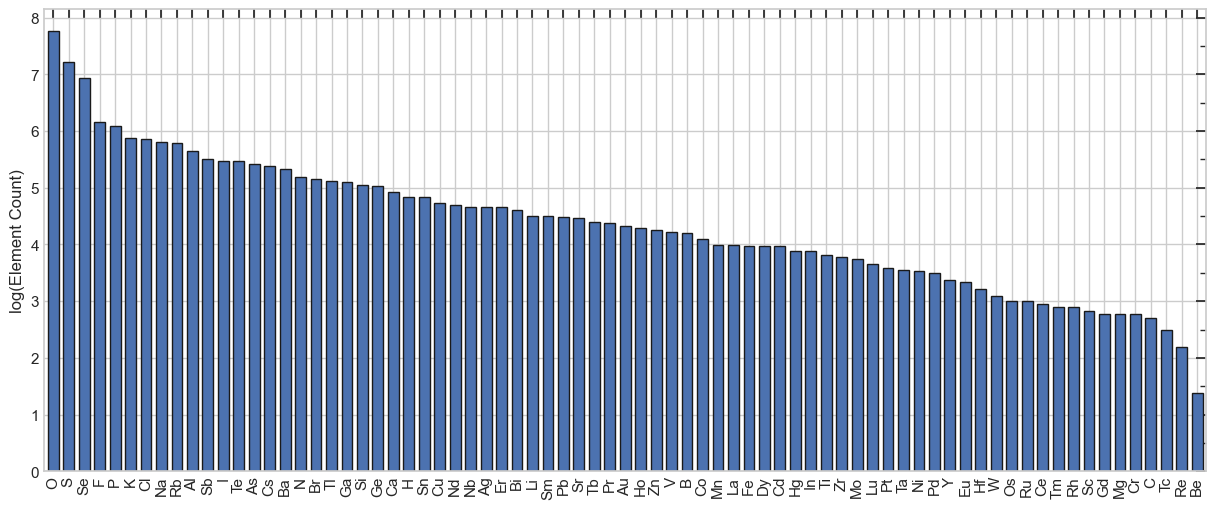

In [18]:
# 误差小于0.1eV的元素分布
from Utools.ML_figures.figures import element_prevalence
import matplotlib.pyplot as plt

data_df = dft_test[dft_test['error'] < 0.1].copy()
current_dir = os.getcwd()
os.chdir('./Utools')  # Change to where ML_figures is a direct subdirectory

formula = data_df['composition']
save_dir = os.path.join(fig_path, 'error_less_than_0.1eV_elements_distribution')
os.makedirs(save_dir, exist_ok=True)
element_prevalence(formula,
                   name='element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=True)

plt.rcParams.update({'font.size': 12})
element_prevalence(formula,
                   name='element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=True)

os.chdir(current_dir)  # Return to previous directory